# FWI Wildfire Workflow - Hazard

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

This workflow aims to provide a simple tool to visualise wildfire hazard using the [Fire Weather Index](https://confluence.ecmwf.int/pages/viewpage.action?pageId=283569774) (FWI) data available on the Copernicus Climate Data Store. The FWI is a climatic index combining data on daily noon surface air temperature, rainfall intensity, wind speed and relative humidity accounting for the effect of fuel moisture and weather conditions on fire behaviour. It consists of a 0-100 score indicating how suitable the climate conditions are for the occurrence of wildfire.

This workflow allows us to visualise spatial and temporal trends in FWI intensity and to understand changes in the fire weather season duration and onset based on FWI. Variations in seasonal FWI intensity determine how chaning climate conditions are influencing the likelihood of wildfire development. An increase in seasonal FWI score suggests a warming and drying pattern in the mean climate leading to more favourable conditions for wildfire development. On the other hand, understanding changes in the fire weather season length is important for adaptation planning as it indicates for how long regions are at risk of wildfire development. This information is fundamental for an effective allocation of resources to wildfire response units, that might need to be significantly reinforced in drying regions experiencing a significant lengthening of the critical fire weather season. 

## Load libraries
In this notebook we will use the following Python libraries:

In [1]:
import glob
import json
import os
import re
import urllib
import zipfile

import pandas as pd
import numpy as np
import geopandas as gpd
import cdsapi
import xarray as xr
import pyproj
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import TwoSlopeNorm

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [json](https://docs.python.org/3/library/json.html) - To read GeoJson files.
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files.
- [urllib](https://docs.python.org/3/library/urllib.html) - To download data from various repositories.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - To extract files from zipped folders.
- [numpy](https://numpy.org/doc/stable/index.html) - To make calculations and handle data in the form of arrays.
- [pandas](https://pandas.pydata.org/docs/index.html) - To store data in the form of DataFrames.
- [geopandas](https://geopandas.org/en/stable/index.html) - To read georeferenced files as DataFrames.
- [cdsapi](https://pypi.org/project/cdsapi/) - To download data from the Copernicus Climate Data Storage. 
- [xarray](https://docs.xarray.dev/en/stable/) - To access data in netCDF4 format.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [pyproj](https://pyproj4.github.io/pyproj/stable/) - To reproject data between different coordinate systems.
- [matplotlib](https://matplotlib.org/) and [Basemap](https://matplotlib.org/basemap/stable/)  - For plotting.
:::

## Create the directory structure
First, we need to set up the directory structure to make the workflow run.
The next cell will create the directory called 'FWI_workflow' in the same directory where this notebook is saved. A directory for data and one for results will also be created inside the main workflow directory to store the downloaded data and the final plots. 

In [2]:
workflow_dir = 'FWI_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)

## Define the studied area

The cells below allow to download the boundaries of any NUTS2 or NUTS3 region in the EU as a GeoJson file given the region code (in this case FI19 for Western Finland). You can look up the NUTS code for all EU regions [here](https://ec.europa.eu/eurostat/documents/3859598/15193590/KS-GQ-22-010-EN-N.pdf) by simply searching the document for the region name. 

The coordinates of the selected regions are extracted and saved in an array. Finally, the geometry of the GeoJson file is saved as a shapefile to be used in the plotting phase.

In [3]:
region = ['ES51'] #Replace the code in [''] with that of your region 

In [4]:
#auxiliary function to load region GeoJson file.
def load_nuts_json(json_path):
    # dependencies: json, urllib, geopandas, 
    while True:
        uh = urllib.request.urlopen(json_path)
        data = uh.read()
        break  
    gdf = gpd.GeoDataFrame.from_features(json.loads(data)["features"])
    gdf['Location'] = gdf['CNTR_CODE'] 
    gdf = gdf.set_index('Location')
    #gdf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
    return gdf

# load nuts2 spatial data
json_nuts_path = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326.geojson'
nuts = load_nuts_json(json_nuts_path)
nuts = nuts.loc[nuts['NUTS_ID'].isin(region)]

#extract coordinates
df=gpd.GeoSeries.get_coordinates(nuts)
coords_user=df.to_numpy()

#save geometry as shapefile
nuts_name=re.sub(r'[^a-zA-Z0-9]','',str(nuts.iloc[0,4]))
nuts_shape=nuts.geometry.explode(index_parts=True).to_file(f'{data_dir}/{nuts_name}.shp')

The code below creates the study area bounding box using the coordinates of the region GeoJson file. The coordinates are then reprojected from the source projection to the climate data projection.

In some cases, it might be needed to expand the selected area through the 'scale' parameter to avoid the corners of the region being left out from the data extraction. The units of the 'scale' parameter are degrees, so setting scale=1 will increase the extraction area by approximately 100 km. A scale of 0-0.5 should be sufficient to fully cover most regions.  

:::{warning} The larger the scale parameter, the larger the extracted area, the longer the workflow will run for. Thus, the user is invited to have a first run of the workflow with scale=0.5, then increase it if not satisfied with the data coverage of the final map.

In [5]:
# set the scale parameter
scale=0.5

#defining region bounding box
bbox=[np.min(coords_user[:,0])-scale,np.min(coords_user[:,1])-scale,np.max(coords_user[:,0])+scale,np.max(coords_user[:,1])+scale]

#setting up the projection transformation tool
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EURO-CORDEX projection.
RLON_MIN, RLAT_MIN = transformer.transform(bbox[1], bbox[0])
RLON_MAX, RLAT_MAX = transformer.transform(bbox[3], bbox[2])

## 1. Changes in seasonal FWI intensity

### Download the climate datasets

The seasonal Fire Weather Index data is sourced from the [Copenicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=form).The projections are readily accessible to the public through the Climate Data Store (CDS) portal. The EURO-CORDEX data can be downloaded through the CDS API as shown below. It is necessary to specify four parameters for the download: the time period, the emission scenario, the model used for the projections and the "severity" of the projection. 

The seasonal FWI represents the mean fire weather index value over the European fire season (June-September). This is calculated as the sum of the daily fire weather index over the European fire season divided by the total number of days within this date range. Seasonal FWI data comes in 5 years timeframes and in this example we selected two of them, 2046-2050 and 2051-2055. For the emission scenario we selected RCP2.6 out of the 4 available in total, with historical, RCP4.5 and RCP8.5 being the other options. We selected the multi-model ensemble mean as the source of the projection as this provides the highest robustness of results. Finally, for the severity of the projections the user can decide between 'best', 'worst' or 'mean' case scenarios, with the latter selected for this example.  

To download the data through the API below you will need to register an account on the Copernicus CDS. A complete guide on how to set up the API can be found [here](https://cds.climate.copernicus.eu/api-how-to). Once your API is set-up, run the cell to download the data. 

In the cell below, specify the RCP scenario and the starting years you are interested in. 

In [6]:
rcp_download='rcp2_6'
rcp='rcp26'
ystart=[2046,2051]

Run the cell below to download the FWI data.

:::{important} To select a different severity scenario, replace the 'multi_model_mean_case' string in the **product type** specification with either 'multi_model_best_case' or 'multi_model_worst_case'.

:::{warning} The download could take a few minutes (depending on your internet speed) due to the large dataset to download and the availability of the Copernicus repository. Once it starts, the status bar below the cell will keep you updated on the status of the download.

In [ ]:
#Remove previously downloaded data for the same rcp and starting year.
for i in ystart:
    pattern = f'{data_dir}/mean-model_{rcp}_fwi-mean-jjas*{i}*.nc'
    for file_path in glob.glob(pattern):
        if os.path.exists(file_path):
            os.remove(file_path)
    
zip_path_cordex = os.path.join(data_dir, 'FWI_cordex_data.zip')

URL = 'https://cds-beta.climate.copernicus.eu/api'
KEY = None # use your key for the CDS API

c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'sis-tourism-fire-danger-indicators',
    {
        'format': 'zip',
        'time_aggregation': 'seasonal_indicators',
        'product_type': 'multi_model_mean_case',
        'variable': 'seasonal_fire_weather_index',
        'experiment': rcp_download,
        'period': [
            '2046_2050', '2051_2055',
        ],
        'version': 'v2_0',
    },
    zip_path_cordex)

with zipfile.ZipFile(zip_path_cordex, 'r') as zObject:
    zObject.extractall(path=data_dir)

### Explore the data
The downloaded files from CDS have a filename structure that describes the exact dataset contained. The general structure for FWI files is the following:

   {model}-{experiment}-fwi-{severity}-{season}-{startyear}-{endyear}-{version}.nc

Load one of the files and explore the content and structure of the dataset. Notice the dimensions, coordinates, data variables, indexes and attributes as well as the description of the spatial reference system in rotated_pole().


:::{important} When you download a new dataset, replace the filename in the cell below with the new one.

In [7]:
# Open the netCDF file as a dataset using xarray
dataset_example = xr.open_mfdataset(f'{data_dir}/mean-model_{rcp}_fwi-mean-jjas_20460101_20501231_v2.nc', 
                                                  decode_coords='all')
# Display said dataset
dataset_example

<xarray.Dataset> Size: 10MB
Dimensions:        (rlon: 424, rlat: 412, time: 5, bnds: 2)
Coordinates:
  * rlon           (rlon) float64 3kB -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 3kB -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    rotated_pole   |S1 1B ...
    time_bnds      (time, bnds) datetime64[ns] 80B dask.array<chunksize=(5, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 40B 2045-11-01 ... 2049-11-01
    lon            (rlat, rlon) float64 1MB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat            (rlat, rlon) float64 1MB dask.array<chunksize=(412, 424), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    fwi-mean-jjas  (time, rlat, rlon) float64 7MB dask.array<chunksize=(5, 412, 424), meta=np.ndarray>
Attributes: (12/13)
    creation_date:  2021-06-29-T15:24:57Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    License:        
    comment:        None

### Extract the climate data for the studied region

In the cell below the FWI datasets are concatenated (if more than one), then cut for the studied region. 

In [7]:
# Auxiliary function to slice each dataset to a particular region with rotated coordinates.
def cut_to_region(ds):
    ds = ds.sel(rlat = slice(RLAT_MIN, RLAT_MAX), rlon = slice(RLON_MIN, RLON_MAX))
    return ds

In [8]:
# Import the FWI file, concatenate years and cut for the chosen region
ds_FWI=xr.open_mfdataset(f'{data_dir}/mean-model_{rcp}_fwi-mean-jjas*.nc', combine='nested',
                         concat_dim='time',
                         decode_coords='all',
                         preprocess=cut_to_region)

# Extract the FWI variable from the imported dataset
FWI=ds_FWI['fwi-mean-jjas']

### Plotting the results

The cells below plots the seasonal FWI intensity. The first cell plots the averaged FWI over the selected period, while the second plots the yearly values. The plotting procedure steps are described within each cell. Before the plots, a table is shown to help the user interpreting the FWI results using the fire danger categorization of the European Forest Fire Information System ([EFFIS](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-danger-forecast#:~:text=The%20Fire%20Weather%20Index%20is,Middle%20East%20and%20North%20Africa.https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-danger-forecast#:~:text=The%20Fire%20Weather%20Index%20is,Middle%20East%20and%20North%20Africa.)). The categorization applied to the FWI values in the table is representative of pan-European conditions and should only be interpreted as a general guideline. High latitude regions are unlikely to experience FWI values above 30, but this does not mean that they are not at risk of wildfire. 

| FWI value | Fire Danger Class |
| --- | --- |
| < 11.2 | Low |
| 11.2 - 21.3 | Moderate |
| 21.3 - 38.0 | High |
| 38.0 - 50.0 | Very High |
| 50.0 - 70.0 | Extreme |
| > 70 | Very Extreme |

:::{tip} Use the 'zoom' paramerter to set how much you would like the final plot to be zoomed-out from the region boundaries (0=no zoom out,1=100 km). Here a zoom of 0.5 degrees (50 km) is used.

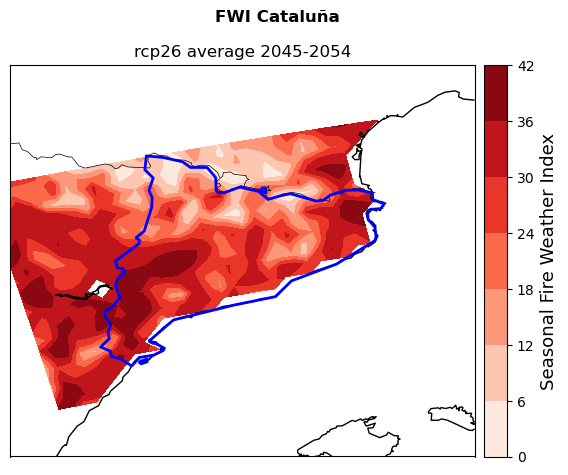

In [10]:
# Plot the seasonal FWI averaged over the selected period

ystart=ds_FWI['time.year'][0].to_numpy() #identify the projection start year
yend=ds_FWI['time.year'][-1].to_numpy() #identify the projection end year
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=ds_FWI['lon'].to_numpy()
lat_plot=ds_FWI['lat'][:].to_numpy()

#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawcountries()
map_FWI.contourf(lon_plot,lat_plot,FWI.mean(axis=0),cmap='Reds',zorder=1) 
map_FWI.colorbar().set_label('Seasonal Fire Weather Index',fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('FWI '+str(nuts.iloc[0,4]),fontweight='bold') #title
plt.title(rcp+' '+'average'+' '+str(ystart)+'-'+str(yend))
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_SeasonalFWI.png') #save plots in results directory
plt.show()

In [ ]:
# Plot the seasonal FWI for every year in the selected period

period=len(ds_FWI['time']) #identify length of studied period in years
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=ds_FWI['lon'].to_numpy()
lat_plot=ds_FWI['lat'][:].to_numpy()

for i in range(period):
    fig=plt.figure()
    fig.add_subplot(1,1,1)
    map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])
    map_FWI.drawcoastlines()
    map_FWI.drawcountries()
    map_FWI.contourf(lon_plot,lat_plot,FWI[i],cmap='Reds',zorder=1) 
    map_FWI.colorbar().set_label('Fire Weather Index',fontsize=13)
    map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
    plt.suptitle('FWI '+str(nuts.iloc[0,4]),fontweight='bold') #title
    plt.title(rcp+' '+str(FWI[i]['time.year'].to_numpy()))
    plt.tight_layout()
    plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+str(FWI[i]['time.year'].to_numpy())+'_SeasonalFWI.png') #save plots in results directory
    plt.show()

## 2. Fire Season Length

To gather information about the fire weather season length we need daily FWI data. As for the seasonal data, daily FWI are downloaded from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=form). These are available for the historical, RCP2.6, RCP4.5 and RCP8.5 scenarios from a number of global climate models as shown in the table below. 

| Global Climate Model | Historical | RCP2.6 | RCP4.5 | RCP8.5 |
| --- | --- | --- | --- | --- |
| noresm1_m | Yes | Yes | No | Yes |
| mpi_esm_lr | Yes | Yes | Yes | Yes |
| cnrm_cm5 | Yes | No | Yes | Yes |
| ec_earth | Yes | Yes | Yes | Yes |
| ipsl-cm5a-mr | Yes | No | Yes | Yes |
|hadgem2-es | Yes | Yes | Yes | Yes |

The cell below downloads FWI data for the historical period (1985-2005) from all the global climate models available. Data from the historical period are used as the baseline to calculate future changes. Again, the download is performed using the CDS API.

In [9]:
#Define historical period for download, here all available years are selected.
yrs=np.arange(1985,2005)
period=[str(a) for a in yrs]

In [ ]:
#Create path for downloaded data
zip_path_cordex_hist = os.path.join(data_dir, 'FWI_cordex_hist.zip')

URL='https://cds-beta.climate.copernicus.eu/api'

c = cdsapi.Client()

c.retrieve(
    'sis-tourism-fire-danger-indicators',
    {
        'format': 'zip',
        'time_aggregation': 'daily_indicators',
        'product_type': 'single_model',
        'variable': 'daily_fire_weather_index',
        'gcm_model': ['cnrm_cm5','ipsl_cm5a_mr',
            'ec_earth', 'hadgem2_es', 'mpi_esm_lr',
            'noresm1_m',
        ],
        'experiment': 'historical',
        'period': period,
        'version': 'v2_0',
    },
    zip_path_cordex_hist)

with zipfile.ZipFile(zip_path_cordex_hist, 'r') as zObject:
    zObject.extractall(path=data_dir)

os.remove(zip_path_cordex_hist)

The cell below downloads daily FWI data for the future. You can **specify the RCP scenario and years** you would like to explore, here RCP2.6 and the period 2050-2060 are selected. 

:::{warning} As shown in the table, data for the RCP2.6 and RCP4.5 scenarios are available only from 4 and 5 climate models, respectively. 

In [10]:
#Select the RCP scenario
experiment=['rcp2_6','rcp4_5','rcp8_5']
rcp_download=experiment[0] #experiment[0]=rcp2_6 , experiment[1]=rcp4_5 , experiment[2]='rcp8_5'
rcp=rcp_download.replace("_","")

#Define the future period, 2021 to 2100 available
period=np.arange(2050,2060)
period=[str(a) for a in period]

In [ ]:
#Remove previously downloaded files for the same scenario
pattern = f'{data_dir}/eur11_rca4_*{rcp}*_fwi*.nc'.nc'
for file_path in glob.glob(pattern):
    if os.path.exists(file_path):
        os.remove(file_path)


#Path for downloaded data
zip_path_cordex_daily = os.path.join(data_dir, 'FWI_cordex_data.zip')

URL='https://cds.climate.copernicus.eu/api/v2'
#KEY=#### INSERT YOUR OWN ####

c = cdsapi.Client(url=URL,key=KEY)

c.retrieve(
    'sis-tourism-fire-danger-indicators',
    {
        'format': 'zip',
        'time_aggregation': 'daily_indicators',
        'product_type': 'single_model',
        'variable': 'daily_fire_weather_index',
        'gcm_model': ['cnrm_cm5','ipsl_cm5a_mr',
            'ec_earth', 'hadgem2_es', 'mpi_esm_lr',
            'noresm1_m'
        ],
        'experiment': rcp_download, 
        'period': period,
        'version': 'v2_0',
    },
    zip_path_cordex_daily)

#Extract downloaded files in the workflow data directory
with zipfile.ZipFile(zip_path_cordex_daily, 'r') as zObject:
    zObject.extractall(path=data_dir)

### Extraction

The cell below groups the downloaded data by model concatenating the yearly files. First, a list of model names for each scenario, as reported in the file names, is defined to enable the loop. 

In [ ]:
#List with names of models as appearing in the file names

models=['ICHEC-EC-EARTH','MOHC-HadGEM2','MPI-M-MPI-ESM-LR','NCC-NorESM1-M',
          'CNRM-CERFACS-CNRM-CM5','IPSL-IPSL-CM5A-MR']

#Loop through the downloaded files, concatenate yearly files from the same model and add them to the list.
hist_arrays=[]
for i in models:
    hist_arrays.append((xr.open_mfdataset(f'{data_dir}/eur11_rca4_*{i}*_historical_fwi-daily-proj*', combine='nested',
                         concat_dim='time',
                         decode_coords='all',
                         preprocess=cut_to_region)))
    
fut_arrays=[]
for i in models:
    try:
        fut_arrays.append((xr.open_mfdataset(f'{data_dir}/eur11_rca4_*{i}*_*{rcp}*_fwi-daily-proj*', combine='nested',
                         concat_dim='time',
                         decode_coords='all',
                         preprocess=cut_to_region)))
    except OSError:
        #prints message if the selected future scenario is not available for a model
        print(f'No files found for model {i} in {rcp}, skipping.')

The cell below averages the daily FWI values across the 6 models. Before calculating the mean, all the models are aligned to the same standard calendar with 365 days.

In [12]:
#align the calendar of models in the historical period
hist=[]
for model in hist_arrays:
    hist.append(model.convert_calendar('noleap',align_on='date'))
    
#align the calendar of models in the future period
fut=[]
for model in fut_arrays:
    fut.append(model.convert_calendar('noleap',align_on='date'))

### Preliminary data processing

In the cells below, the length of the fire weather season is calculated for every selected year as the sum of the **fire weather days**, which are the days when FWI is higher than a designated **FWI threshold**. The length of the fire weather season is calculated in the historical and in the future periods to quantify the projected future changes. 

The user can decide to set their own FWI threshold to define a fire weather day, choosing the most appropriate value for their region based on local knowledge and needs (Table 1). In this example, a FWI value of 30 is used.  

:::{important} You can set your own FWI threshold by modifying the 'user_thresh' variable below with a numeric FWI value. For instance, if you are intersted in assessing the length of the 'extreme' fire weather season (Table 1) you could set user_tresh=50, so that all the days with FWI>50 are counted. 

In [23]:
#FUTURE season length
#set user threshold choosing the thresh_hist calculated above or setting a numerical value
user_thresh=30

#mask days above the threshold and count them in each year after concatenating data from all models
conc_fut=xr.concat(fut,dim='model')
mask_fut=conc_fut['fwi-daily-proj'] > user_thresh
count_fut=mask_fut.groupby('time.year').sum(dim='time')

conc_hist=xr.concat(hist,dim='model')
mask_hist=conc_hist['fwi-daily-proj'] > user_thresh
count_hist=mask_hist.groupby('time.year').sum(dim='time')

### Data manipulation and Plotting

#### Fire weather season length map

The cell below plots the fire weather season length in the historical and future periods at every point in the region. For both periods, "best","worst" and "mean" case conditions are presented. The worst and best case scenarios are obtained respectively summing and subtracting the inter-model and inter-annual standard deviation of the fire weather season from the mean. In this way, the user is presented with the range of possible conditions covering 95% of the possible distribution. 

In [24]:
#Calculate the inter-model and inter-annual mean
count_fut_m=count_fut.mean(dim=('model','year'))
count_hist_m=count_hist.mean(dim=('model','year'))

In [25]:
#Calculate the worst and best case scenarios for the future
worst_fut=count_fut_m+1.96*count_fut.std(dim=('model','year'))
best_fut=np.where(count_fut_m-1.96*count_fut.std(dim=('model','year'))<0,0,
                  count_fut_m-1.96*count_fut.std(dim=('model','year')))

In [26]:
#Calculate the worst and best case scenarios for the historical period
worst_hist=count_hist_m+1.96*count_hist.std(dim=('model','year'))
best_hist=np.where(count_hist_m-1.96*count_hist.std(dim=('model','year'))<0,0,
                  count_hist_m-1.96*count_hist.std(dim=('model','year')))

The cell below plots two figures, one for the historical and one for the future period, showing the maps for the best worst and mean case scenarios.

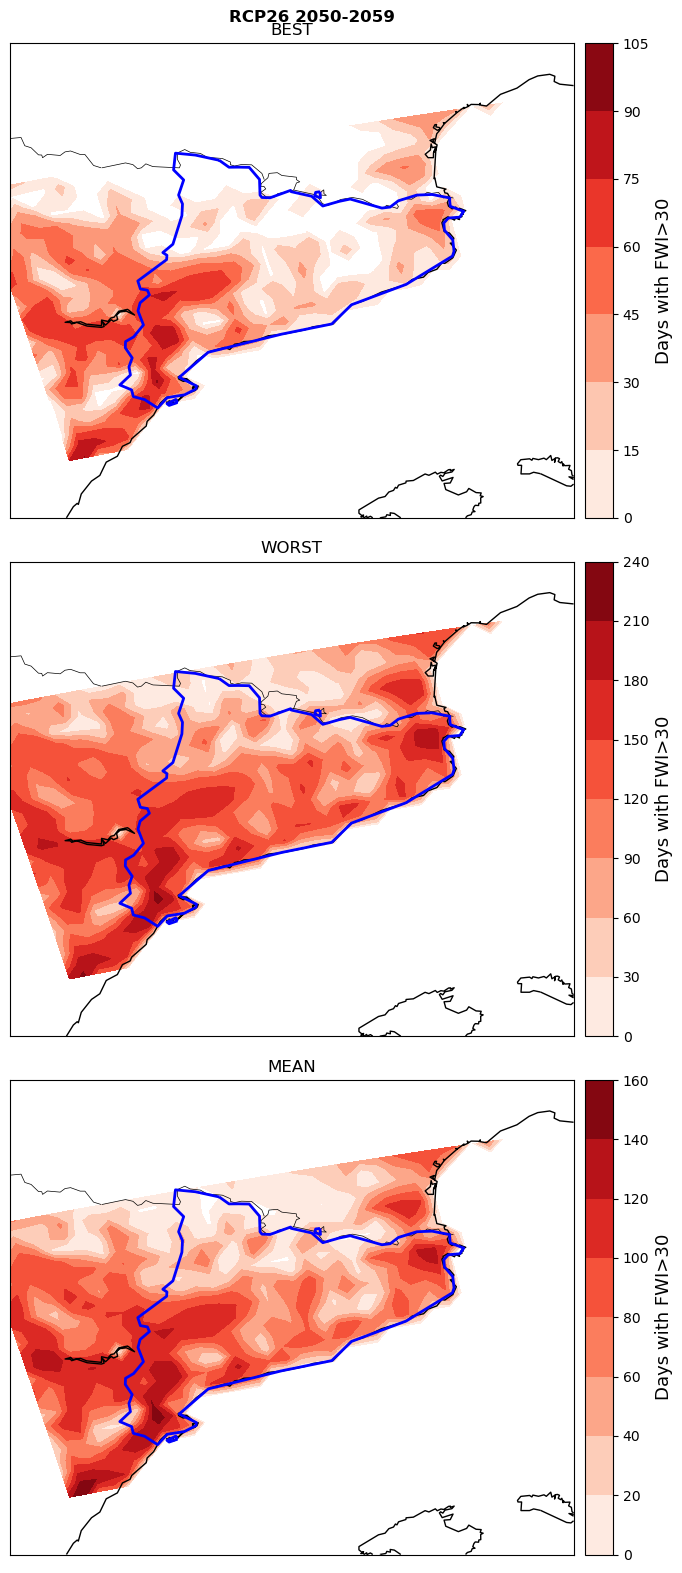

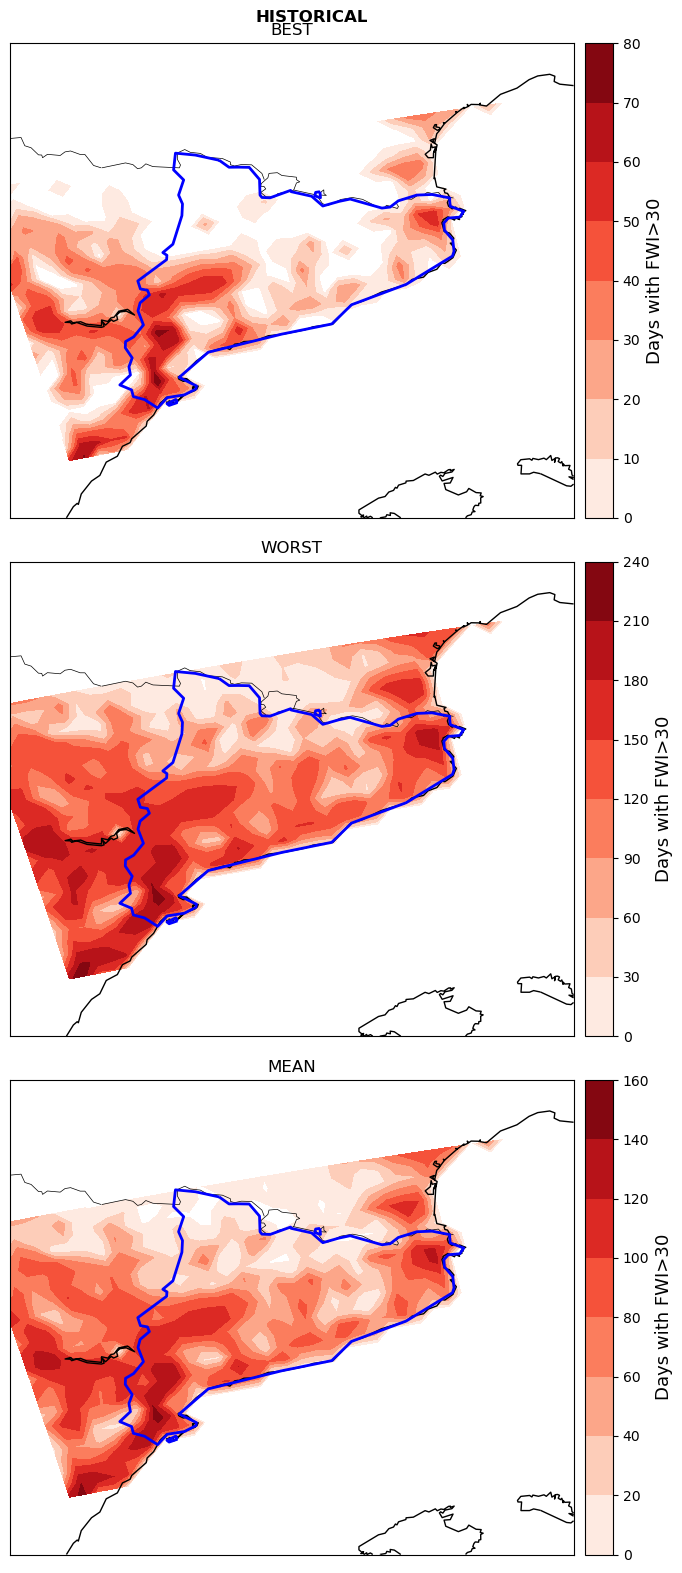

In [58]:
#Set plotting parameters
zoom=0.5 
levels=np.arange(-1,2)
fut_scens=[best_fut,worst_fut,count_fut_m]
hist_scens=[best_hist,worst_hist,count_hist_m]
scens=['BEST','WORST','MEAN']

#define the longitude and latitude coordinates
lon_plot=count_fut_m['lon'].to_numpy()
lat_plot=count_fut_m['lat'][:].to_numpy()

#plotting loop
fig=plt.figure(figsize=(9,16))
for i in np.arange(3):
    fig.add_subplot(3,1,i+1)
    map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])
    map_FWI.drawcoastlines()
    map_FWI.drawcountries()
    map_FWI.contourf(lon_plot,lat_plot,fut_scens[i],cmap='Reds')#,norm=w_norm,zorder=1) 
    map_FWI.colorbar().set_label('Days with FWI>'+str(np.round(user_thresh,0)),fontsize=13)
    map_FWI.contourf(lon_plot,lat_plot,fut_scens[i],colors='w',zorder=1,levels=levels)
    map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
    plt.title(scens[i])
plt.suptitle(rcp.upper()+' '+period[0]+'-'+period[-1],fontweight='bold') #title
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_'+rcp+
            '_FWI'+str(np.round(user_thresh,0))+'FUT_SPATIAL.png') #save plots in results directory

fig=plt.figure(figsize=(9,16))
for i in np.arange(3):
    fig.add_subplot(3,1,i+1)
    map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])
    map_FWI.drawcoastlines()
    map_FWI.drawcountries()
    map_FWI.contourf(lon_plot,lat_plot,hist_scens[i],cmap='Reds')#,norm=w_norm,zorder=1) 
    map_FWI.colorbar().set_label('Days with FWI>'+str(np.round(user_thresh,0)),fontsize=13)
    map_FWI.contourf(lon_plot,lat_plot,hist_scens[i],colors='w',zorder=1,levels=levels)
    map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
    plt.title(scens[i])
plt.suptitle('HISTORICAL',fontweight='bold') #title
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_'+rcp+
            '_FWI'+str(np.round(user_thresh,0))+'HIST_SPATIAL.png') #save plots in results directory



The historical and future maps allow to understand how the fire weather season length might evolve with climate change. Comparing the results across different cases (i.e., best,worst,mean), the user can understand what is the possible range of predicted change. The best and worst case scenarios will often be significantly different from each other and from the mean, mostly deriving from the differences in FWI prediction produced by different climate models. Climate models tend to produce slightly different predictions for raw climate variables, like temperature and solar radiation, but these are amplified when calculating a composite indicators like FWI. This variability in the results should not be considered as lack of accuracy, as all the values falling within the best and worst cases are equally likely to occur. Instead, the user should use these opposite cases as an indication of the most positive and negative (i.e., extreme) conditions that might occur in the region. As with any other climate variable, being aware of the magnitude of the fire weather season length extremes is fundamental to design effective and resilient adaptation measures.

## Conclusions

In this workflow we learned how to use the Fire Weather Index to collect information about the weather-related likelihood of wildfire development. In the first part we used the seasonal FWI to assess the suitability of climate conditions for fire development in the hisotrical record and in a future emission scenario, comparing them to get temporal series and maps showing the effect of climate change on the regional wildfire development risk. In the second part, we used the daily FWI to evaluate the future evolution of the fire weather season, defined as the number of days with FWI higher than the user-defined fire danger threshold. In particular, we used the daily FWI to estimate the range of the fire weather season length across the region in the future and historical scenarios.

The plots produced by this workflow allow the user to get a comprehensive set of information on the weather-related fire danger of their region, including both spatially and temporally distributed results. In addition, the data produced in this workflow will be used as the danger component of the wildfire risk assessment produced by the FWI Risk workflow. 

## Contributors

Euro-Mediterranean Center on Climate Change (CMCC), Italy.

Author of the workflow: Andrea Rivosecchi

### References
El Garroussi, S., Di Giuseppe, F., Barnard, C., & Wetterhall, F. (2024). Europe faces up to tenfold increase in extreme fires in a warming climate. Npj Climate and Atmospheric Science, 7(1). https://doi.org/10.1038/s41612-024-00575-8


